In [1]:
import numpy as np
import pandas as pd
import datetime

Загрузим справочник классов и переделаем его в словарь:

In [34]:
classesData = pd.read_excel("../../data/Справочники/Кабель справочник МТР.xlsx")
classesDict = dict(map(lambda i,j : (i,j) , classesData['Материал'].to_numpy(), classesData['Класс'].to_numpy()))
classToIndex = dict(map(lambda i,j : (i,j) , classesData['Класс'].unique(), range(len(classesData['Класс'].unique()))))

In [64]:
classesAmount = len(classesData['Класс'].unique())

Загрузим данные по поставщикам, грузополучателям и входной файл для лотирования:

In [3]:
X = pd.read_excel("../Ayrat/purchases_input_format.xlsx")
suppliers = pd.read_csv("suppliersClassified")
recievers = pd.read_csv("cargoRecieversClusterized.csv")
X.insert(15, '№ лота', np.zeros(len(X), dtype=int))
X.insert(16, 'Класс', [classesDict[i] for i in X['Материал'].to_numpy()])

In [4]:
X.head()

,Клиент,Материал,Краткий текст материала,ЕИ,Общее количество,Месяц поставки,Год поставки,Полугодие,Срок поставки,Грузополучатель,Цена,Способ закупки,№ заказа,№ позиции,Дата заказа,№ лота,Класс
0,64025,770000594878,"Кабель ИнСил-ОЭвзнг(А)-ХЛ 4х2х1,0-660",КМ,0.695,8,2020,0,2020-08-30,20001383,1102185.23,Конкурентный отбор,10928863,50,2020-01-07,0,G2106
1,64025,770000831667,"Кабель К9РВСБПМнг(А)-HF 4х1,5ок(N)-1",КМ,0.320,10,2020,0,2020-10-10,20001383,292004.92,Конкурентный отбор,10928863,60,2020-01-07,0,G21050101
2,57650,770000869461,"Провод ПуВнг(А)-LS 1х1,0 (PE)",КМ,0.030,8,2020,0,2020-08-30,20000537,43892.67,Конкурентный отбор,10929730,210,2020-01-10,0,G210511
3,57650,770000869463,"Провод ПуГВнг(А)-LS 1х6,0 (PE)",КМ,0.030,8,2020,0,2020-08-30,20000537,85400.00,Конкурентный отбор,10929730,220,2020-01-10,0,G210511
4,57650,770000869464,Провод ПуГВ-ХЛ 1х4 (РЕ),КМ,0.015,8,2020,0,2020-08-30,20000537,137902.67,Конкурентный отбор,10929730,230,2020-01-10,0,G210511


ГДЕ-ТО ЗДЕСЬ НАДО ВПИСАТЬ ОЧИСТКУ ДАННЫХ, КАК У АЙРАТА. СЕЙЧАС СЧИТАЕМ ДАННЫЕ ЧИСТЫМИ

In [5]:
suppliers.head()

,Unnamed: 0,Кредитор,П/индекс,Город,G2170,G21050101,G2110,G21050102,G21050301,G210402,...,G2114,G2112,G210102,G210505,G210503,G210516,G2104,G2108,G2111,G210510
0,51,59,629807.0,Г.О. ГОРОД НОЯБРЬСК,4,3,2,207,0,2,...,0,0,0,0,0,9,1,0,0,0
1,1052,1198,162608.0,ГОРОД ЧЕРЕПОВЕЦ,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1525,1754,628464.0,ГОРОД РАДУЖНЫЙ,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5204,5811,644040.0,ГОРОД ОМСК,12,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7724,8536,644040.0,ГОРОД ОМСК,0,3,8,68,1,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
suppliersIndicators = suppliers[classesData['Класс'].unique()].to_numpy().astype(bool)

In [6]:
recievers.head()

,Unnamed: 0.1,Unnamed: 0,code,address,coord,label
0,0,25,20001088,"Вынгапуровское м/р, куст № 404","(63.145377, 76.954688)",10
1,1,26,20001070,"Стахановское м/р, ГПЭС","(54.250000, 53.750000)",91
2,2,27,20002638,"Томская обл., Александровский р-н, Советское н...","(60.750556, 77.248889)",3
3,3,28,20000437,"13 км автодороги Нижневартовск - Мегион, ООО ""...","(60.938545, 76.558902)",3
4,4,29,20000443,"13 км автодороги Нижневартовск- Мегион, ООО ""С...","(60.938545, 76.558902)",3


In [8]:
clusters = np.sort(recievers['label'].unique())

In [9]:
clusterByIDDict = dict(map(lambda i,j : (i,j) , recievers['code'].to_numpy(),recievers['label'].to_numpy()))
IDsByCluster = {i: recievers[recievers['label'] == i]['code'].to_numpy() for i in clusters}

Замечание: большинство поставщиков за всю историю предлагали продать что-либо меньше 10 раз. Возможно, в будущем стоит разработать алгоритм, поощряющий подстраивание лотов под тех поставщиков, которые появлялись в истории бОльшее число раз. Сейчас мы на это внимания не обращаем:

Посмотрим, какие временные рамки у наших данных:

In [11]:
X['Дата заказа'][1]

'2020-01-07'

Скоммуниздим попутно вспомогательный метод для итерации по месяцам

In [12]:
from dateutil.rrule import rrule, MONTHLY
from datetime import datetime
import re

def month_iter(start_month, start_year, end_month, end_year):
    start = datetime(start_year, start_month, 1)
    end = datetime(end_year, end_month, 1)

    return ((d.month, d.year) for d in rrule(MONTHLY, dtstart=start, until=end))

In [13]:
dateBegin, dateEnd = X['Дата заказа'][[1, len(X['Дата заказа'])-1]]

In [14]:
dateBegin, dateEnd

('2020-01-07', '2024-04-01')

In [15]:
yearBegin, monthBegin, yearEnd, monthEnd = int(dateBegin[:4]), int(dateBegin[5:7]), int(dateEnd[:4]), int(dateEnd[5:7])

In [16]:
dateColumn = X['Дата заказа']

Начнём наше нечестивое лотирование (если его здесь нет, то я просто не всунул его в основной цикл. Теория лотирования уже готова):

In [20]:
a = 0
M = 0
for m in month_iter(monthBegin, yearBegin, monthEnd, yearEnd):
    dateMaskString = r'{:04d}-{:02d}-*'.format(m[1], m[0])
    mask = dateColumn.str.match(dateMaskString)
    clusterDFs = [0]*len(clusters)
    X_month = X[mask]
    b = 0
    for i, cluster in enumerate(clusters):
        clusterDFs[i] = X_month[X_month['Грузополучатель'].isin(IDsByCluster[cluster])]
        if len(clusterDFs[i]) > 0:
            a += 1
            print(len(clusterDFs[i]))
            M = max(M, len(clusterDFs[i]['Класс'].unique()))
        if len(clusterDFs[i]) == 238:
            A = clusterDFs[i]
    #if a == 860:
    #    print(X[mask].index)
    #    break
    #a += len(X[mask])
print(a)

1
15
29
25
238
235
106
30
1
153
5
22
9
59
56
4
76
2
70
2
1
12
3
8
1
39
87
21
123
1
30
3
2
44
2
69
41
46
72
64
17
13
6
286
3
25
9
2
72
40
30
76
2
45
6
10
1
19
13
22
5
303
108
9
97
6
11
9
16
2
3
1
1
4
131
122
170
69
5
160
6
4
12
11
8
5
6
13
4
92
7
3
1
19
6
18
7
7
54
21
36
1
85
171
14
91
15
1
1
16
34
20
6
1
19
59
30
1
59
1
2
154
1
2
2
50
1
1
6
2
191
215
12
146
1
3
68
1
6
1
34
146
1
16
42
2
95
3
40
3
11
8
102
20
260
138
14
67
2
8
13
6
46
4
137
3
7
216
132
7
4
229
2
6
3
8
1
7
4
2
6
1
1
3
6
3
5
16
89
90
83
36
11
2
42
9
8
14
12
5
1
11
68
48
17
25
10
46
6
86
59
31
70
40
11
317
99
262
113
30
1
54
1
49
35
22
10
5
1
1
1
21
2
19
82
586
38
5
2
8
87
3
2
34
55
3
6
36
119
443
27
11
3
29
1
84
9
8
3
16
1
85
2
199
452
432
28
4
16
2
2
2
183
13
100
3
22
5
20
6
2
1
2
12
1
6
5
3
10
1
191
12
29
113
92
4
47
6
65
3
9
98
4
18
54
3
3
19
41
43
78
53
49
113
7
215
2
2
2
9
39
12
59
134
10
22
17
84
84
5
4
80
4
3
7
8
147
47
57
71
23
1
6
131
23
25
23
8
2
1
4
6
3
55
18
11
50
100
595
4
74
43
3
1
26
20
35
35
14
48
69
4
16


In [21]:
M

20

In [22]:
A

,Клиент,Материал,Краткий текст материала,ЕИ,Общее количество,Месяц поставки,Год поставки,Полугодие,Срок поставки,Грузополучатель,Цена,Способ закупки,№ заказа,№ позиции,Дата заказа,№ лота,Класс
49,59,770000294682,"Кабель ВБШвнг(А)-ХЛ 5х50мк(N,PE)-1",КМ,0.200,6,2020,0,2020-06-01,20000221,1850085.72,Прочие закупки,10930786,460,2020-01-14,0,G21050102
50,59,1246476,"Кабель ВБШвнг(А)-ХЛ 3х2,5ок-0,66",КМ,0.105,6,2020,0,2020-06-01,20000221,68048.22,Прочие закупки,10930786,990,2020-01-14,0,G21050102
51,59,770000027223,"Кабель КВВГЭнг(А)-LS 10х1,5",КМ,0.300,6,2020,0,2020-06-01,20000221,121159.83,Прочие закупки,10930786,1000,2020-01-14,0,G210502
52,59,1246476,"Кабель ВБШвнг(А)-ХЛ 3х2,5ок-0,66",КМ,0.243,6,2020,0,2020-06-01,20000221,76546.50,NaN,10930786,1230,2020-01-14,0,G21050102
53,59,1246476,"Кабель ВБШвнг(А)-ХЛ 3х2,5ок-0,66",КМ,0.108,6,2020,0,2020-06-01,20000221,68233.00,NaN,10930786,1240,2020-01-14,0,G21050102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459,59,770000652859,"Кабель ВБШвнг(А)-ХЛ 3х10ок(N,PE)-1",КМ,0.500,9,2020,0,2020-09-10,20000221,337643.50,Конкурентный отбор,10932276,70,2020-01-17,0,G21050102
460,59,770000872371,Кабель ВБШвнг(А)-ХЛ 3х35ок-1,КМ,1.300,7,2020,0,2020-07-31,20000221,1592696.52,Конкурентный отбор,10932276,80,2020-01-17,0,G21050102
461,59,770000872349,"Кабель ВБШвнг(А) 3х25ок(N,PE)-0,66",КМ,1.300,9,2020,0,2020-09-11,20000221,1141946.16,Конкурентный отбор,10932276,90,2020-01-17,0,G21050102
462,59,770000873029,Кабель ВБШвнг(А)-ХЛ 3х120мс-6,КМ,1.300,9,2020,0,2020-09-25,20000221,5683640.64,Конкурентный отбор,10932276,110,2020-01-17,0,G21050102


## Агломеративная кластеризация + метод Монте-Карло

Назовём **подзадачей** пару "кластер грузополучателей" + "месяц, год". 

Заметим (из ограничений на время подачи заявок в лоте и независимости нашей кластеризации грузополучателей от времени), что для решения задачи лотирования нам надо решить набор независимых друг от друга подзадач. Таким образом, решим конкретную подзадачу $A$ из таблицы выше. На ней мы будем проводить эксперименты. 

**Лот** - это прямое произведение отрезка времени длиной до 30 дней и вектора индикаторных функций, показывающих, что данный лот содержит заявки классов:

$$
L_i = [t^i_0, t^i_1] \oplus (\alpha^i_1, ... \alpha^i_{N_{cl}})
$$

, где $\alpha^i_k \in (0, 1)$, $N_{cl}$ - количество классов. **Размером лота** $|L_i|$ будем называть количество заявок в нём.

**Ансамбль лотов**, он же **решение** подзадачи, - это такой набор лотов, что для заявок $x = (t_x, \alpha^x_1, ..., \alpha^x_{N_{cl}}); \exists! k(x) < N_{cl}, \alpha^x_k = 1; \forall m(x) \neq k, \alpha^x_m = 0$ подзадачи $A = [0, T_A] \oplus (\alpha^A_1, ..., \alpha^A_{N_{cl}})$:

$$
\forall x \in A, \exists! L_i, x \in L_i
$$

(то есть каждая заявка подзадачи покрывается ровно одним лотом)

Определим для каждого лота **энергию**:

$$
E_i = 1 - \Lambda M_i |L_i| / |A|
$$,

где $M_i$ - метрика качества кластеризации МТР по пересечениям поставщиков из описания задачи, $|A|$ - количество заказов в подзадаче, а $\Lambda > 0$ - гиперпараметр.

*Из анализа реализации алгоритма над  модельной подзадачей $A$ (ниже) стало ясно, что имеет большой смысл домножать "метрический" член на $|L_i| / |A|$ - иначе задача скатывается или в большое количество лотов с одним классом, или малое с ужасными метриками на них.*

Просуммировав по всем $n$ лотам, получим **энергию ансамбля**:

$$
E_A = n - \Lambda \sum^n_i M_i
$$

Заметим, что минимизация этой энергии приводит к повышению метрик $MQ$ и $M$ из описания задачи.

Рассмотрим теперь два лота $L_i$, $L_j$ и их объединение $L_{i \cup j}$ (естественно, с соблюдением ограничения $|[t^{i \cup j}_0, t^{i \cup j}_1]| < \tau_{max}$, где $\tau_{max}$ - 30 дней):

$$
E_i = 1 - \Lambda M_i
$$

$$
E_j = 1 - \Lambda M_j
$$

$$
E_{i \cup j} = 1 - \Lambda M_{i \cup j}
$$

Сравним эти энергии:

$$
E_{i \cup j} - (E_i + E_j) = -1 - \Lambda (M_{i \cup j} - M_i - M_j)
$$

Проанализируем получившееся выражение: при сильном увеличении метрики отдельного лота в случае объединения (новая метрика больше суммы двух прошлых) энергия ансамбля будет меньше при любом параметре  $\Lambda$. При нулевом (или **малом**) $\Lambda$ объединение (с учетом ограничения по времени) будет всегда **выгодно**. При **большом** параметре $\Lambda$ новый лот должен иметь если и не лучшую метрику по сравнению со старыми, то не сильно хуже точно (т.е. объединение чаще **невыгодно**)

Опишем **шаг** поиска лучшего решения подзадачи:

На первом шаге создадим лоты единичного размера на каждой заявке: заявка $x_i$ порождает лот $L^0_i$. Полученный набор лотов будет ансамблем лотов $\Omega_0$ с количеством лотов $|\Omega_0|$ и энергией $E_{\Omega_0}$

Затем проведём пробное **объединение** двух случайных лотов $L^0_{\nu}$ и $L^0_{\mu}$ ($\nu, \mu < |\Omega_0|$) в $L'$. Получим новый ансамбль $\Omega'_0$ с количеством лотов на 1 меньше и новой энергией $E_{\Omega'_0}$. 

Новый ансамбль $\Omega_1$ будет или новым с вероятностью $P(0 \rightarrow 0') = min(1, exp(- \beta (E_{\Omega'_0} - E_{\Omega_0}))$, или старым с вероятностью $P(0 \rightarrow 0) = 1 - P(0 \rightarrow 0')$.

*На этом этапе у нас появился новый гиперпараметр $\beta$ - в методе Монте-Карло он имеет смысл обратной температуры. При больших его значениях (малой температуре) система быстро найдёт локальный минимум энергии и в нём и останется. При большой же температуре ($\beta$ маленький) мы получим обширный набор ансамблей $\{\Omega_n\}$ (назовём его **фазовое пространство**), причём в этом наборе система бывает +- во всех локальных минимумах в окрестности глобального минимума, но чаще всего в этом наборе она будет в глобальном минимуме или вблизи него.*

Только что мы определили операцию объединения лотов. Теперь определим операцию **разделения** лота $L_i$ из ансамбля на два других.

Сначала случайно выберем, разделять его по времени или по классам:

1) **По времени**: случайно выберем одну (не первую и не последнюю по времени) заявку $x^i_m \in L_i$. $x^i_m = (t^i_m, \alpha^x_1, ..., \alpha^x_{N_{cl}})$. Разделим $L_i$ на $L^1_i$ и $L^2_i$ так, что в первом лоте - заявки $x^i_k$ с $t^i_k \leq t^i_m$, во втором - заявки с $t^i_k > t^i_m$.
2) **По классам**: пусть количество классов заявки $L_i$ равно $N_i$ и само их множество обозначим $G_i$. Выберем случайно число $k \sim Uniform(1, N_i-1)$ (можно продлить до $(0, N_i)$, но тогда лот перейдёт в сам себя и пустой лот) (а вообще это распределение можно менять - например, повысить вероятность малых $k$). Случайно выберем $k$ классов из тех, что есть в лоте $L_i$ - получим набор классов $G_1$. Оставшиеся будут набором $G_2$. В $L^1_i$ перейдут заявки с классами $G_1$, в $L^2_i$ перейдут заявки с классами $G_2$.

Таким образом, опишем **весь алгоритм** поиска лучшего решения:

Выбираем на шаге $n$ с имеющимся ансамблем $\Omega_n$ равновероятно одну из двух операций: объединение или разъединение. 

 1) В случае объединения случайно выбираем пару лотов, которые объединяем и объединение которых удовлетворяет ограничению по времени.
 2) В случае разъединения выбираем случайный лот, для которого равновероятно проводим разделение по времени или по классам. 

В любом случае получаем ансамбль $\Omega'_n$. Принимаем его как $\Omega_{n+1}$ с вероятностью 
$P(n \rightarrow n') = min(1, exp(-\beta(E_{\Omega'_n} - E_{\Omega_n})))$. Иначе $\Omega_{n+1} = \Omega_n$.

Повторяем алгоритм на шаге $n+1$

...

В итоге мы получим набор ансамблей $\{\Omega_n\}$, распределённых по Больцману: $P(\Omega_n) \sim exp(-\beta E_{\Omega_n})$. *Хотя нам знание распределения ничего особо не даст, т.к. по фазовому пространству усреднять мы ничего не будем. Больший смысл имеет для нас следующее утверждение:*

В данном наборе есть ансамбль с минимальной энергией. Назовём его **оценкой идеального решения** и подадим в качестве результата:

$$
\Omega^A_{ideal} \approx \Omega_k; \Omega_k \in \{\Omega_n\}_n, E_{\Omega_k} = min \{E_{\Omega_n}\}_n
$$

В идеальном случае последние по $n$ элементы набора лежат в окрестности этой оценки - тогда мы можем быть уверены, что результат алгоритма это хотя бы локальный минимум по энергии. Но, вообще говоря, каждая подзадача требует своего исследования сходимости даного алгоритма с подбором своих параметров $\Lambda$ и $\beta$

### Реализация алгоритма

In [530]:
import datetime
import copy
import matplotlib.pyplot as plt

In [170]:
class Order():
    def __init__(self, x):
        self.index = x[0]
        self.deliveryTime = datetime.date(int(x[1][:4]), int(x[1][5:7]), int(x[1][8:10]))
        self.classId = x[2]

    def __eq__(self, other):
        return (self.getID() == other.getID()) and (self.getTime() == other.getTime()) and (self.getClass() == other.getClass())
 
    def getTime(self):
        return self.deliveryTime

    def getClass(self):
        return self.classId

    def getID(self):
        return self.index

def timeDif(x: Order, y: Order):
    return x.getTime() - y.getTime()

In [548]:
class Lot():
    def __init__(self, xs, suppliers=None):
        self.xs = copy.copy(xs)
        if len(xs) == 0:
            return None
        self.beginDate = min([x.getTime() for x in xs])
        self.endDate = max([x.getTime() for x in xs])
        if (len(xs) == 1):
            self.M = 9.0
        elif (suppliers != None):
            #я не хочу трахаться с мгновенным расчётом метрик для случая, когда входной лист заказов не размера 1...
            self.M = self.metrics(suppliers)
        else:
            self.M = None

    def getOrders(self):
        return self.xs

    def add(self, xs):
        self.beginDate = min(self.beginDate, min([x.getTime() for x in xs]))
        self.endDate = max(self.endDate, max([x.getTime() for x in xs]))
        self.xs += copy.copy(xs)

    def getTimes(self):
        return [x.getTime() for x in self.getXs()]

    def divideByClasses(self, classes):
        indices = []
        xs = []
        for i, x in enumerate(self.getXs()):
            if classes[x.getClass()] == True:
                indices.append(i)
        for index in sorted(indices, reverse=True):
            xs.append(self.getXs()[index])
            del self.xs[index]
        self.beginDate = min(self.beginDate, min([x.getTime() for x in self.getXs()]))
        self.endDate = max(self.endDate, max([x.getTime() for x in self.getXs()]))
        return xs

    def divideByTime(self, date):
        #print(date)
        indices = []
        xs = []
        for i, x in enumerate(self.getXs()):
            #print(x.getTime())
            #print(x.getTime() > date)
            if (x.getTime() >  date):
                indices.append(i)
                #print('a')
        for index in sorted(indices, reverse=True):
            xs.append(self.getXs()[index])
            del self.xs[index]
        self.beginDate = min(self.beginDate, min([x.getTime() for x in self.getXs()]))
        self.endDate = max(self.endDate, max([x.getTime() for x in self.getXs()]))
        #print(xs[0])
        return xs

    def __len__(self):
        return len(self.getXs())

    def getXs(self):
        return copy.copy(self.xs)

    def classesVector(self):
        global classesAmount
        classes = np.zeros(classesAmount, dtype=bool)
        for x in self.getXs():
            classes[x.classId] = True
        return classes

    def similarityToSupplier(self, supplier):
        classes = self.classesVector()
        return np.sum((classes * supplier), axis=-1)
    
    def metrics(self, suppliers):
        if len(self.getXs()) == 0:
            return None
        similarities = self.similarityToSupplier(suppliers) / np.sum(self.classesVector())
        eps = 10e-3
        n05 = np.sum([similarities >= 0.5])
        n08 = np.sum([similarities >= 0.8])
        n10 = np.sum([similarities >= 1 - eps])
        n00 = np.sum([similarities >= eps])
        return (2.0 * n05 + 3.0 * n08 + 4.0 * n10) / n00

    def getDateBoundary(self):
        return [self.beginDate, self.endDate]

    def __eq__(self, other):
        if len(self.getXs()) != len(other.getXs()):
            return False
        else:
            return True

def lotTimeViable(L1, L2, timeConstraint):
    aL1, bL1 = L1.getDateBoundary()
    aL2, bL2 = L2.getDateBoundary()
    a = min(aL1, aL2)
    b = max(bL1, bL2)
    delta = b - a
    return delta.days <= timeConstraint

def conjugate(L1, L2):
    return Lot(L1.getXs().extend(L2.getXs()))

In [199]:
A['Срок поставки'].unique()

array(['2020-06-01', '2020-09-30', '2020-08-13', '2020-07-31',
       '2020-08-31', '2020-12-26', '2020-06-23', '2020-09-04',
       '2021-01-30', '2021-01-29', '2020-09-17', '2020-09-10',
       '2020-09-11', '2020-09-25', '2020-06-20'], dtype=object)

In [323]:
A.head()

,Клиент,Материал,Краткий текст материала,ЕИ,Общее количество,Месяц поставки,Год поставки,Полугодие,Срок поставки,Грузополучатель,Цена,Способ закупки,№ заказа,№ позиции,Дата заказа,№ лота,Класс
49,59,770000294682,"Кабель ВБШвнг(А)-ХЛ 5х50мк(N,PE)-1",КМ,0.200,6,2020,0,2020-06-01,20000221,1850085.72,Прочие закупки,10930786,460,2020-01-14,0,G21050102
50,59,1246476,"Кабель ВБШвнг(А)-ХЛ 3х2,5ок-0,66",КМ,0.105,6,2020,0,2020-06-01,20000221,68048.22,Прочие закупки,10930786,990,2020-01-14,0,G21050102
51,59,770000027223,"Кабель КВВГЭнг(А)-LS 10х1,5",КМ,0.300,6,2020,0,2020-06-01,20000221,121159.83,Прочие закупки,10930786,1000,2020-01-14,0,G210502
52,59,1246476,"Кабель ВБШвнг(А)-ХЛ 3х2,5ок-0,66",КМ,0.243,6,2020,0,2020-06-01,20000221,76546.50,NaN,10930786,1230,2020-01-14,0,G21050102
53,59,1246476,"Кабель ВБШвнг(А)-ХЛ 3х2,5ок-0,66",КМ,0.108,6,2020,0,2020-06-01,20000221,68233.00,NaN,10930786,1240,2020-01-14,0,G21050102


In [324]:
A['Срок поставки']

49     2020-06-01
50     2020-06-01
51     2020-06-01
52     2020-06-01
53     2020-06-01
          ...    
459    2020-09-10
460    2020-07-31
461    2020-09-11
462    2020-09-25
758    2020-06-20
Name: Срок поставки, Length: 238, dtype: object

In [325]:
x_indices = A.index.to_numpy()
x_dates = A['Срок поставки'].to_numpy()
x_classes = np.array([classToIndex[i] for i in A['Класс'].to_numpy()])
x = [(x_indices[i], x_dates[i], x_classes[i]) for i in range(len(A))]

In [327]:
orderList = [Order(i) for i in x]

In [329]:
lotList = [Lot([i]) for i in orderList]

In [461]:
L1 = Lot([orderList[0]])
L2 = Lot([orderList[10]])

In [462]:
L1.getDateBoundary()

[datetime.date(2020, 6, 1), datetime.date(2020, 6, 1)]

In [463]:
L2.getDateBoundary()

[datetime.date(2020, 9, 30), datetime.date(2020, 9, 30)]

In [464]:
lotTimeViable(L1, L2, 30)

False

In [500]:
MEGALOT = Lot(orderList)

In [501]:
MEGALOT.metrics(suppliersIndicators)

0.35255570117955437

In [502]:
len(MEGALOT)

238

In [503]:
MEGALOT.classesVector()

array([False,  True, False,  True,  True, False, False,  True, False,
        True, False, False,  True, False, False, False, False, False,
       False, False,  True, False,  True,  True, False, False, False,
       False, False, False, False, False, False,  True, False,  True,
       False, False, False, False])

In [504]:
testClasses = np.zeros(classesAmount)

In [505]:
testClasses.astype(bool)
testClasses[0:5] = True

In [506]:
c = copy.copy(MEGALOT)

In [507]:
len(c)

238

In [508]:
MINILOT = Lot(MEGALOT.divideByClasses(testClasses))

In [509]:
np.nonzero(MEGALOT.classesVector())[0], np.nonzero(MINILOT.classesVector())[0]

(array([ 7,  9, 12, 20, 22, 23, 33, 35]), array([1, 3, 4]))

In [485]:
len(MINILOT) + len(MEGALOT)

238

In [486]:
len(c)

96

Тест лотирования на $A$:

In [820]:
np.random.seed(42)
clusterSize = len(A)
iterationsAmount = 20000
Lambda = 1.0
beta = 0.2
timeConstraint = 30
Ls = [Lot([i]) for i in orderList]
#energy = np.sum([1 - Lambda * L.metrics(suppliersIndicators) for L in Ls])
energy = np.sum([1 - Lambda * L.metrics(suppliersIndicators) * len(L) / clusterSize for L in Ls])
energies = np.zeros(iterationsAmount)
energiesTrue = np.zeros(iterationsAmount)
print(energy)
L2s = []
for i in range(iterationsAmount):
    if (i % 1000 == 0):
        print(i, energy)
    energies[i] = energy
    length = len(Ls)
    conjunction = np.random.choice([False, True])
    if conjunction:
        k, l = np.random.choice(range(length), size=2, replace=False)
        L1 = Ls[k]
        L2 = Ls[l]
        if lotTimeViable(L1, L2, timeConstraint):
            L3 = Lot(L1.getXs() + L2.getXs())
            e1 = 1 - Lambda * L1.metrics(suppliersIndicators) * len(L1) / clusterSize
            e2 = 1 - Lambda * L2.metrics(suppliersIndicators) * len(L2) / clusterSize
            e3 = 1 - Lambda * L3.metrics(suppliersIndicators) * len(L3) / clusterSize
            #e1 = 1 - Lambda * L1.metrics(suppliersIndicators)
            #e2 = 1 - Lambda * L2.metrics(suppliersIndicators)
            #e3 = 1 - Lambda * L3.metrics(suppliersIndicators)
            deltaE = e3 - e2 - e1
            P = np.exp(- beta * deltaE)
            decision = np.random.rand() < P
            if decision:
                del Ls[max(k, l)]
                del Ls[min(k, l)]
                Ls += [L3]
                energy += deltaE
    else:
        k = np.random.choice(range(length), size=None, replace=False)
        if np.sum(Ls[k].classesVector()) <= 1:
            continue
        divideByClass = np.random.choice([False, True])
        if divideByClass:
            dividerSize = np.random.choice(range(1, np.sum(Ls[k].classesVector())))
            dividerIndices = np.random.choice(np.nonzero(Ls[k].classesVector())[0], size=dividerSize, replace=False)
            newClasses = np.zeros(classesAmount, dtype=bool)
            newClasses[dividerIndices] = True
            e0 = 1 - Lambda * Ls[k].metrics(suppliersIndicators) * len(Ls[k]) / clusterSize
            #e0 = 1 - Lambda * Ls[k].metrics(suppliersIndicators)
            L2 = Lot(Ls[k].divideByClasses(newClasses))
            #e1 = 1 - Lambda * Ls[k].metrics(suppliersIndicators)
            #e2 = 1 - Lambda * L2.metrics(suppliersIndicators)
            e1 = 1 - Lambda * Ls[k].metrics(suppliersIndicators) * len(Ls[k]) / clusterSize
            e2 = 1 - Lambda * L2.metrics(suppliersIndicators) * len(L2) / clusterSize
            deltaE = e1 + e2 - e0
            P = np.exp(- beta * deltaE)
            decision = np.random.rand() < P
            if decision:
                Ls += [L2]
                energy += deltaE
            else:
                Ls[k].add(L2.getXs())
        divideByTime = np.random.choice([False, True])
        if divideByTime and (len(np.unique(Ls[k].getTimes())) > 1):
            timeDivider = np.random.choice(np.unique(Ls[k].getTimes()))
            e0 = 1 - Lambda * Ls[k].metrics(suppliersIndicators) * len(Ls[k]) / clusterSize
            #e0 = 1 - Lambda * Ls[k].metrics(suppliersIndicators)
            L2 = Lot(Ls[k].divideByTime(timeDivider))
            if len(L2) == 0:
                continue
            e1 = 1 - Lambda * Ls[k].metrics(suppliersIndicators) * len(Ls[k]) / clusterSize
            e2 = 1 - Lambda * L2.metrics(suppliersIndicators) * len(L2) / clusterSize
            #e1 = 1 - Lambda * Ls[k].metrics(suppliersIndicators)
            #e2 = 1 - Lambda * L2.metrics(suppliersIndicators)
            deltaE = e1 + e2 - e0
            P = np.exp(- beta * deltaE)
            decision = np.random.rand() < P
            if decision:
                Ls += [L2]
                energy += deltaE
            else:
                Ls[k].add(L2.getXs())

229.0
0 229.0
1000 124.48348944366269
2000 91.71093914601323
3000 50.85971212708432
4000 29.822467828882758
5000 14.097201397821868
6000 10.223397929588348
7000 10.880060231709267
8000 11.114356261717443
9000 7.5525131922274715
10000 11.19299982501144
11000 11.94091570527417
12000 9.70378690552326
13000 6.506544052140951
14000 7.253286576587754
15000 10.165926247252601
16000 10.322407433993254
17000 7.652582982548203
18000 9.749920423648428
19000 9.787712247281243


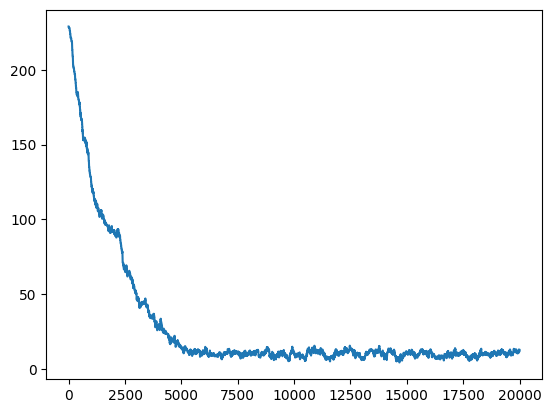

In [821]:
plt.plot(energies)

In [822]:
np.sum([energies <= np.min(energies) + 10e-3])

3

In [823]:
a = 0
E = 0
for L in Ls:
    #a += len(L)
    E += 1 - Lambda * L.metrics(suppliersIndicators)
    print(L.metrics(suppliersIndicators), len(L), np.sum(L.classesVector()))

9.0 3 1
9.0 29 1
9.0 10 1
9.0 5 1
9.0 1 1
9.0 12 1
9.0 6 1
9.0 15 1
4.6892655367231635 37 2
9.0 1 1
9.0 1 1
9.0 10 1
3.3628318584070795 17 2
3.575829383886256 3 2
9.0 11 1
9.0 19 1
2.994832041343669 2 2
2.183848797250859 55 3
9.0 1 1


Получилось что-то сходящееся, да и Бог с ним.

А теперь провернём весь фарш наоборот: начнём вытягивать айдишники из каждого лота и строить словарь айди-лот:

In [826]:
np.sum([1 - Lambda * L.metrics(suppliersIndicators) * len(L) / clusterSize for L in Ls])

12.766807552374706